In [1]:
import numpy as np
import pandas as pd
import json
from pprint import pp
import tldextract
from scipy import stats

from retrieval_importance import split, learn_importance, encode_retrievals, encode_groups, grouped_weights, \
    most_important_groups, least_important_groups, retrievals_from_json, evaluate, evaluate_pruned, \
    tune_pruning_threshold, mode

np.random.seed(1311)

In [2]:
#application = 'imputation'
#task = 'restaurant_bing_minilm'
#task = 'buy_bing_minilm'

application = 'question_answering'
task = 'wikifact__director'


retrievals = retrievals_from_json(f'./applications/{application}/{task}.jsonl')

In [3]:
sample_to_inspect = retrievals[0]
pp(sample_to_inspect, width=100, compact=True)

{'question': 'The director of Disparaît, v is',
 'correct_answers': ['Andrei Severny'],
 'retrieved_answers': ['Andrei Severny', 'Andrei Severny', 'Andrei Severny', 'Auraeus Solito',
                       'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito',
                       'Auraeus Solito.', 'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito',
                       'Auraeus Solito', 'Auraeus Solito', 'Aureaus Solito.', 'Aureaus Solito',
                       'Auraeus Solito', 'Auraeus Solito', 'Aureaus Solito', 'Aureaus Solito.',
                       'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito',
                       'Aureaus Solito', 'Auraeus Solito', 'Aureaus Solito', 'Auraeus Solito',
                       'Auraeus Solito', 'Aureaus Solito', 'Auraeus Solito', 'Aureaus Solito',
                       'Jacques Feyder.', 'Aureaus Solito', 'Aureaus Solito', 'Auraeus Solito',
                       'Jacques Feyder.', 'Auraeus So

In [4]:
def utility(retrieved, prediction):
    if prediction in retrieved["correct_answers"]:
        return 1.0
    else:
        return 0.0

And we define how to **group the data sources** in the corpus, in this example, we group the websites returned from Bing by domain. We aim to **learn the data importance per group**.

In [5]:
def group(source):    
    url_parts = tldextract.extract(source)
    return f'{url_parts.domain}.{url_parts.suffix}'    

Split data into validation and test set (LLM not retrained/fine-tuned, so no training data required)

In [6]:
validation, test = split(retrievals, 0.5)

Learn data importance based on multilinear extension of the utility function, using k=10 for generating predictions via majority vote

In [7]:
encoded_retrievals, mapping = encode_retrievals(validation, "retrieved_websites", "retrieved_answers", utility)
grouping, group_mapping = encode_groups(mapping, group)

k = 10

weights = learn_importance(encoded_retrievals, k=k, learning_rate=10, num_steps=100, n_jobs=-1, grouping=grouping)
domain_weights = grouped_weights(weights, grouping, group_mapping)

Inspect 5 most important data sources

In [8]:
most_important_groups(domain_weights, 5)

[('alchetron.com', 1.0),
 ('allmovie.com', 1.0),
 ('bharatpedia.org', 1.0),
 ('cine.com', 1.0),
 ('everipedia.org', 1.0)]

Inspect 5 least important data sources

In [9]:
least_important_groups(domain_weights, 5)

[('avclub.com', 0.0),
 ('goodreads.com', 0.0),
 ('kinorium.com', 0.0),
 ('quora.com', 0.0),
 ('reddit.com', 0.0)]

## Determing a pruning threshold on the validation set

Goal: improve performance on task by pruning retrieval corpus based on learned importances. Approach: remove data sources with a weight below a given treshold. Tuning the threshold on our validation set.

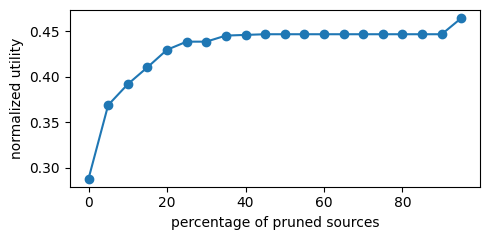

Found best (normalized) utility of 0.46444 on validation set with threshold 0.50758, pruning 95 percent of domains.


In [10]:
import matplotlib.pyplot as plt

percentile_range = range(0, 100, 5)

tuning_result = tune_pruning_threshold(validation, domain_weights, percentile_range, 
                                       utility, group, k, normalize=True)

plt.plot(percentile_range, tuning_result.achieved_utilities, marker='o')     
plt.ylabel('normalized utility')
plt.xlabel('percentage of pruned sources')

plt.gcf().set_size_inches(5, 2.5)
plt.tight_layout()
plt.show()
        
print(f'Found best (normalized) utility of {tuning_result.best_utility:.5f} on validation set ' +
      f'with threshold {tuning_result.best_threshold:.5f}, ' + 
      f'pruning {tuning_result.best_percentile} percent of domains.')        

## Final evaluation on unseen test set
    
**Performance (accuracy) with the original retrieval corpus** without pruning    

In [11]:
evaluate(test, utility, k, normalize=True)

0.3074074074074074

**Performance (accuracy) after pruning the retrieval corpus** based on the tuned threshold

In [12]:
evaluate_pruned(test, utility, group, k, tuning_result.best_threshold, domain_weights, normalize=True)

0.4414814814814815